## Synthetic DiD

+ Consider a balanced panel with $N$ units and $T$ time periods, the outcome is $Y_{it}$.

+ Binary treatment id denoted by $W_{it} \in \{0,1\}$, $N_{co}$ (control) units are never treated, $N_{tr}=N-N_{co}$ are treated units. $T_{pre}$ denotes the pre-treatment period, and $T_{post}=T - T_{pre} $ are the post periods.


+ 1. Like with SC methods, we start by finding weights $\hat{\omega}_i^{sdid}$ that align pre-exposure trends in the outcome of unexposed units with those for the exposed units, e.g., 
$$
\sum_{i=1}^{N_{co}} \hat{\omega}_{i}^{sdid}Y_{it} \approx N_{tr}^{-1} \sum_{i=N_{co}+1}^{N} Y_{it} \quad \text{for all} \quad t = 1, \ldots, T_{pre}
$$ 

+ 2. We also look for time weights $\hat{\lambda}^{sdid}_{t}$ that balance pre-exposure time periods with post-exposure ones for control units, e.g. 
$$
\sum_{t=1}^{T_{pre}}\hat{\lambda_t^{sdid}}Y_{it} \approx T_{pre}^{-1}\sum_{t=T_{pre}+1}^TY_{it} \quad \text{for all} \quad i=1, \ldots, N_{co}
$$

+ 3. Then we use these weights in a basic two-way fixed effects regression to estimate the average causal effect of exposure:

\begin{equation}
\tag{1.1}
(\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}, \hat{\beta}) = \underset{\tau,\mu,\alpha,\beta}{\arg\min} \left\{ \sum_{i=1}^{N} \sum_{t=1}^{T} (Y_{it} - \mu - \alpha_{i} - \beta_{t} - W_{it}\tau)^2 \hat{\omega}_{i}^{sdid} \hat{\lambda}_{t}^{sdid} \right\}.
\end{equation}





### 1. The California proposition 99 example
---

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import os
os.chdir('/Users/wang/Desktop/8. Literature Light Map/3. sythetic control')
colors = sns.color_palette()

In [2]:
df = pd.read_stata("data/prop99_example.dta")
df.query("state=='California'").query("year.between(1986, 1990)")

,state,year,packspercapita,treated
662,California,1986,99.699997,0
701,California,1987,97.500000,0
740,California,1988,90.099998,0
779,California,1989,82.400002,1
818,California,1990,77.800003,1


### 2. The TWFE DiD estimator
---

+ In comparison with the SDID, the TWFE DID mothod estimates the effect of treatment exposure by solving the same two-way fixed effects regression problem without either time or unit **`weights`**:

\begin{equation}
\tag{1.2}
(\hat{\tau}^{did}, \hat{\mu}, \hat{\alpha}, \hat{\beta}) = \underset{\alpha,\beta,\mu,\tau}{\arg\min} \left\{ \sum_{i=1}^{N} \sum_{t=1}^{T} (Y_{it} - \mu - \alpha_{i} - \beta_{t} - W_{it}\tau)^2 \right\}.
\end{equation}

In [3]:
# did fixed effect method
did_model = sm.OLS.from_formula('packspercapita ~ 1 + treated + C(state) + C(year)', data=df).fit()
att = did_model.params['treated']
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


+ We can also add treatment indicator indentify the treated state.

+ Add time indicator indentify the post treatment period.

+ Then add an interaction term between treatment and time to get the DiD estimator.

In [4]:
# gen treatment group indicator
df['tr_group'] = df.groupby('state').treated.transform('max')
# gen post treatment period indicator
df['post_period'] = df.groupby('year').treated.transform('max')
# show data
df.query("state=='California'").query("year.between(1986, 1990)")

,state,year,packspercapita,treated,tr_group,post_period
662,California,1986,99.699997,0,1,0
701,California,1987,97.500000,0,1,0
740,California,1988,90.099998,0,1,0
779,California,1989,82.400002,1,1,1
818,California,1990,77.800003,1,1,1


+ The TWEF DiD estimator can also be recovered by the new specification

In [5]:
did_model2 = sm.OLS.from_formula('packspercapita ~ 1 + tr_group*post_period', data=df).fit()
att = did_model2.params['tr_group:post_period']
print("The DiD estimated ATT: ", att.round(3))

The DiD estimated ATT:  -27.349


+ We can visualize it, and see that the TWFE DiD model is the simple four averages and three substractions, namely the cannonical Difference in Differences estimator.

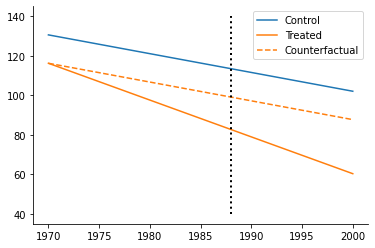

In [6]:
pre_con_y = did_model2.params.Intercept
post_con_y = pre_con_y + did_model2.params.post_period
pre_tr_y = pre_con_y + did_model2.params.tr_group
post_tr_y = pre_tr_y + did_model2.params.post_period + did_model2.params['tr_group:post_period']
conterfactual = pre_tr_y + did_model2.params.post_period
plt.plot([1970, 2000], [pre_con_y, post_con_y], color=colors[0], label="Control")
plt.plot([1970, 2000], [pre_tr_y, post_tr_y], color=colors[1], label="Treated")
plt.plot([1970, 2000], [pre_tr_y, conterfactual], color=colors[1], linestyle='--', label="Counterfactual")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, color="black")
plt.legend(loc="upper right")
sns.despine()

### 3. Demeaned OLS
---

+ Without the TWFE we can also recover the same estimate with demeaned regression.

In [7]:
# demean the outcome variable by state and by time
df['y_demean'] = df.packspercapita - df.groupby('state').packspercapita.transform('mean')
df['y_demean'] = df.y_demean - df.groupby('year').packspercapita.transform('mean')

# demean the treatment indicator by state and by time
df['d_demean'] = df.treated - df.groupby('state').treated.transform('mean')
df['d_demean'] = df.d_demean - df.groupby('year').treated.transform('mean')

+ The key here is to demean all the variables by state and by time. 

+ This is because we want to remove the state and time fixed effects from the outcome variable and the treatment indicator. 

+ This is equivalent to running a regression of the outcome variable on the treatment indicator, state fixed effects, and time fixed effects. 

+ The coefficient on the treatment indicator is the ATT.

In [8]:
fit = sm.OLS.from_formula('y_demean ~ 1 + d_demean', data=df).fit()
print("The DiD estimated ATT is: ", fit.params['d_demean'].round(3))

The DiD estimated ATT is:  -27.349


### 4. Parallel trend assumption (PTA)
---

+ An important assumption for using DiD is that the treatment and control groups would have followed the same trend in the absence of the treatment. 

+ This is called the parallel trends assumption (PTA). 

+ If this assumption is violated, then the DiD estimate will be biased. 

+ Since the PTA is not testable, it is important to check the trends in the outcome variable before and after the treatment.

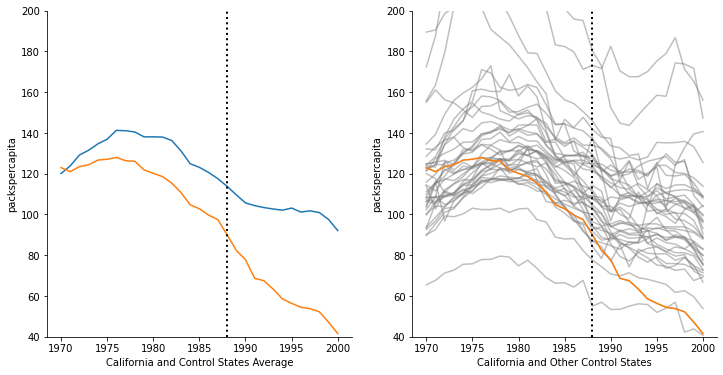

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(df.groupby(['year', 'tr_group']).packspercapita.mean().to_frame().reset_index(), x='year', y='packspercapita', hue='tr_group', ax=ax1)
ax1.legend(title=None)
ax1.set_ylim(40, 200)
ax1.set_xlabel("California and Control States Average")
ax1.get_legend().remove()
ax1.axvline(x=1988, linestyle=':', color='black', lw=2)

sns.lineplot(data=df, x='year', y='packspercapita', hue='state', palette=['gray']*len(df['state'].unique()), alpha=0.5, ax=ax2)
sns.lineplot(data=df.query("state=='California'"), x='year', y='packspercapita', color=colors[1], label='California', ax=ax2)
ax2.set_ylim(40, 200)
ax2.get_legend().remove()
ax2.set_xlabel("California and Other Control States")
ax2.axvline(x=1988, linestyle=':', color='black', lw=2)

sns.despine()

### 5. A event study model
---

In [10]:
# create year dummy
dat = pd.concat([df, pd.get_dummies(df.year, prefix='year')], axis=1)

# drop year 1988 before the treatment
formula ='packspercapita ~ C(state) +' + ' + '.join([f'treated*year_{year}' for year in range(1970, 2001) if year not in [1988]])

# fit the model
fit = sm.OLS.from_formula(formula, data=dat).fit()

In [11]:
datt = pd.DataFrame(index=range(1970, 2001), columns=['coef'])
datt['coef'] = np.concatenate([fit.params[70:88].values, np.array([0]), fit.params[88:].values])
datt['bse'] = np.concatenate([fit.bse[70:88].values, np.array([0]), fit.bse[88:].values])

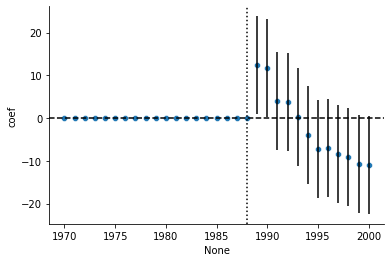

In [12]:
sns.scatterplot(x=datt.index, y='coef', data=datt)
plt.errorbar(x=datt.index, y='coef', yerr=[datt['bse'], datt['bse']], data=datt, fmt='none', color='black')
plt.axvline(x=1988, color='black', linestyle=':')
plt.axhline(y=0, color='black', linestyle='--')
sns.despine()

### 6. The synthetic control method (SCM)
---

+ In comparison with the SDID estimator, the SC estimator omits the unit fixed effect and the time weights from the regression function:
\begin{equation}
\tag{1.3}
(\hat{\tau}^{sc}, \hat{\mu}, \hat{\beta}) = \underset{\mu,\beta,\tau}{\arg\min} \left\{ \sum_{i=1}^{N} \sum_{t=1}^{T} (Y_{it} - \mu - \beta_{t} - W_{it}\tau)^2 \hat{\omega}_{i}^{sc} \right\}.
\end{equation}

+ Under some conditions, SC weighting can account for the unit fixed effects on its own.

+ This happens when the weighted average of the outcomes for the control units is exactly equal to the average of outcomes for the treated units in pre-treatment periods.

+ In practice, this equality holds only approximately, in which case including the unit fixed effects in the weighted regression will remove some of the remaining bias. (``Highly recommanded!``)

+ The benefits of including unit fixed effects in the SC regression can also be obtained by applying SCM after centering the data by subtracting, from each unit’s trajectory, its ``pre-treatment mean``.

+ As we have showed you how demeaned regression can recover the estimate made by fixed effect regression.

In [13]:
from sklearn.utils.validation import check_X_y
from scipy.optimize import minimize, LinearConstraint

In [14]:
# build the control and treated data before the treatment
control = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
treated = df.query("tr_group==1").query("post_period==0").pivot(index='year', columns='state', values='packspercapita').mean(axis=1)
X, y = check_X_y(control, treated)

# Initial guess for the weights
initial_w = (np.ones(X.shape[1])/X.shape[1])

# define the objective function
def objective_fun(w, X, y):
    return np.linalg.norm(y - X @ w)

# define the constraints, sum to 1
constraint = LinearConstraint(np.ones(X.shape[1]), lb= 1, ub= 1)
# define the bounds, all between 0 and 1
bounds = ((0, 1),) * X.shape[1]

# minimize the objective function
res = minimize(objective_fun, x0=initial_w, args=(X, y), method='SLSQP', constraints=constraint, bounds=bounds)

In [15]:
dat = pd.DataFrame(index=range(1970, 2001))
# the actual cigarette consumption in California
dat['packspercapita'] = df.query("state=='California'").packspercapita.values

# the synthetic cigarette consumption in California
dat['fitted'] = df.query("state!='California'").pivot(index='year', columns='state', values='packspercapita')@res.x

# the residual
dat['residual'] = dat['packspercapita'] - dat['fitted']
print("The SCM estimated ATT is: ", dat[dat.index>1988].residual.mean().round(3))

The SCM estimated ATT is:  -19.514


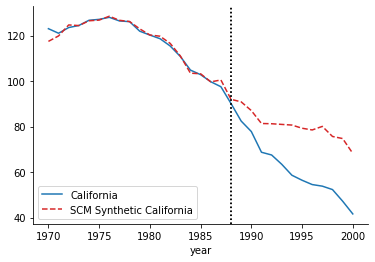

In [16]:
sns.lineplot(df.query("tr_group==1").pivot(index='year', columns='state', values='packspercapita'), color=colors[0])

sns.lineplot(df.query("tr_group==0").pivot(index='year', columns='state', values='packspercapita') @ res.x, color=colors[3], label='SCM Synthetic California', linestyle='--')

plt.axvline(x=1988, color='black', linestyle=':')
plt.legend()
plt.axvline(x=1988, color='black', linestyle=':')
plt.legend()
sns.despine()

### 7. Using SCM is equivalent to WLS demeaned by time dimension
---

+ since the SCM adds weights to units, we do not need to demean by unit


In [17]:
sc_weights = pd.DataFrame()
sc_weights['state'] = control.columns
sc_weights['weight'] = res.x

# merge the weights to the original data
df = df.merge(sc_weights, on='state', how='left').fillna(1/len(sc_weights)) # fill the missing weight with 1/N

# demean the outcome variable and treatment indicator by time
df['y_demean'] = df.packspercapita - df.groupby('year').packspercapita.transform('mean')
df['d_demean'] = df.treated - df.groupby('year').treated.transform('mean')

In [18]:
fit = sm.WLS.from_formula('y_demean ~ 1 + d_demean', data=df, weights=df.weight+(1e-10)).fit()
print("The SCM estimated ATT is: ", fit.params['d_demean'].round(3))

The SCM estimated ATT is:  -19.514


+ The estimate of Synthetic control is much smaller.

+ Synthetic Controls can accommodate non-parallel pre-treatment trends much better. 

+ It is not susceptible to the same bias as Diff-in-Diff.

### 8. Synthetic DiD
---

#### 8.1 first, we compute regularizion parameter $\zeta$

We set the regularization parameter $\zeta$ as:

\begin{align}
\tag{2.2}
\zeta &= (N_{tr}T_{post})^{1/4} \hat{\sigma} \quad with \quad  \hat{\sigma}^2 = \frac{1}{N_{co}(T_{pre}-1)} \sum_{i=1}^{N_{co}} \sum_{t=1}^{T_{pre}-1} (\Delta_{it} - \bar{\Delta})^2 \\

& where \quad \Delta_{it} = Y_{i(t+1)} - Y_{it}, \quad and \quad \bar{\Delta} = \frac{1}{N_{co}(T_{pre}-1)} \sum_{i=1}^{N_{co}} \sum_{t=1}^{T_{pre}-1} \Delta_{it} \notag
\end{align}

In [19]:
# compute the penalty
n = df.query("tr_group==1").state.nunique()
t = df.query('post_period==1').year.nunique()
t_pre = df.query('post_period==0').year.nunique()

sigma = df.query("tr_group==0").query("post_period==0").sort_values('year').groupby('state').packspercapita.diff().std()
ksi = (n*t)**(1/4) * sigma

#### 8.2. second, we compute the unit weights $\omega_i^{sdid}$ by solving:

\begin{align}
(\hat{\omega}_0, \hat{\omega}^{sdid}) &= \underset{\omega_0\in\mathbb{R},\omega\in\Omega}{\arg \min} \ell_{unit}(\omega_0, \omega) \quad where \notag \\

\ell_{unit}(\omega_0, \omega) &= \sum_{t=1}^{T_{\text{pre}}} \left( \omega_0 + \sum_{i=1}^{N_{\text{co}}} \omega_i Y_{it} - \frac{1}{N_{\text{tr}}} \sum_{i=N_{\text{co}}+1}^{N} Y_{it} \right)^2 + \zeta^2 T_{\text{pre}} \|\omega\|_2^2, \tag{2.1} \\

\Omega &= \left\{ \omega \in \mathbb{R}^N_+ : \sum_{i=1}^{N_{co}} \omega_i = 1, \omega_i = N_{tr}^{-1} \: for \: all \: i = N_{co} + 1, \ldots, N \right\} \notag
\end{align}


```Remember:``` That the unit weights $\omega_i^{sdid}$ only focus on pre-treatment period mapping the similarity between control and treated groups!

```Different from SCM```

+ We allow for an intercept term $\omega_0$, meaning that the weights $\omega^{sdid}$ no longer need to make the unexposed pre-trends perfectly match the exposed ones, as long as the trend is parallel.

+ We add a regularization penalty to increase the dispersion, and ensure the uniqueness, of the weights.

In [20]:
# prepare control data and treated data
tr = df.query("tr_group==1").query("post_period==0").pivot(index='year', columns='state', values='packspercapita').mean(axis=1)
con = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
X, y =  check_X_y(con, tr)

# remember to add intercept
X = sm.add_constant(X)

# define the objective function, remember do not penliaty the intercept
def obj_fun_omega(w, X, y, ksi):
    return np.sum((y - X @ w)**2) + ksi**2 * t_pre * np.linalg.norm(w[1:]**2)

# constrain the sum of weights to 1, except fot the intercept
constrain_vec = np.ones(X.shape[1])
constrain_vec[0] = 0
constraint = LinearConstraint(constrain_vec, lb= 1, ub= 1)
# define the bounds, all between 0 and 1, except fot the intercept
bounds = ((-np.inf, np.inf),) + ((0, 1),)* (X.shape[1]-1)

# define the initial weights
initial_w = (np.ones(X.shape[1])/X.shape[1])

res_omega = minimize(obj_fun_omega, x0=initial_w, args=(X, y, ksi), method='SLSQP', constraints=constraint, bounds=bounds)

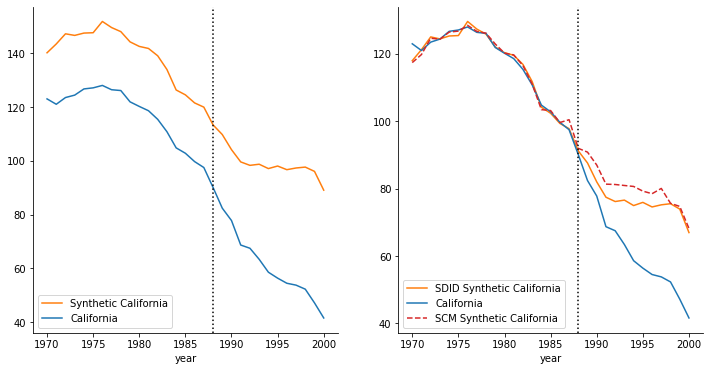

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# without intercept
sns.lineplot(df.query("tr_group==0").pivot(index='year', columns='state', values='packspercapita') @ res_omega.x[1:], color=colors[1], label='Synthetic California', ax=ax[0])
sns.lineplot(df.query("tr_group==1").pivot(index='year', columns='state', values='packspercapita'), color=colors[0], ax=ax[0])

# with intercept
sns.lineplot(df.query("tr_group==0").pivot(index='year', columns='state', values='packspercapita') @ res_omega.x[1:] + res_omega.x[0], color=colors[1], label='SDID Synthetic California', ax=ax[1])
sns.lineplot(df.query("tr_group==1").pivot(index='year', columns='state', values='packspercapita'), color=colors[0], ax=ax[1])
sns.lineplot(df.query("tr_group==0").pivot(index='year', columns='state', values='packspercapita') @ res.x, color=colors[3], label='SCM Synthetic California', linestyle='--', ax=ax[1])

ax[0].axvline(x=1988, color='black', linestyle=':')
ax[0].legend()
ax[1].axvline(x=1988, color='black', linestyle=':')
ax[1].legend()
sns.despine()

+ The intercept allows the treated unit to be on an arbitrarily different level than its synthetic control.

+ New Synthetic Control method is built to have the same pretreatment trend as the treated unit, but not necessarily the same level.

+ We plot the SCM with intercept with conventional SCM, the difference comes both from the fact that we allowed for an intercept and from the $L2$ penalty. 

#### 8.3. third, we need to compute the time weights $\hat{\lambda}_t^{sdid}$ by solving:

\begin{align}
& (\hat{\lambda}_0, \hat{\lambda}^{sdid}) = \underset{\lambda_0\in\mathbb{R},\lambda\in\Lambda}{\arg \min} \ell_{time}(\lambda_0, \lambda) \quad where \notag \\

& \ell_{time}(\lambda_0, \lambda) = \sum_{i=1}^{N_{co}} \left( \lambda_0 + \sum_{t=1}^{T_{pre}} \lambda_t Y_{it} - \frac{1}{T_{post}} \sum_{t=T_{pre}+1}^{T} Y_{it} \right)^2 \tag{2.3} \\

& \Lambda = \left\{ \lambda \in \mathbb{R}^{T_{pre}}_+ : \sum_{t=1}^{T_{pre}} \lambda_t = 1, \lambda_t = T_{post}^{-1} \quad for \: all \quad t = T_{pre} + 1, \ldots, T \right\} \notag
\end{align}

```Remember:``` That the time weights $\lambda_t^{sdid}$ only focus on control group mapping the similarity before and after treatment!

In [22]:
pre = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
post = df.query("tr_group==0").query("post_period==1").pivot(index='year', columns='state', values='packspercapita').mean(axis=0)

X, y = check_X_y(pre.T, post)
# add intercept
X = sm.add_constant(X)

# build abjective function
def obj_fun_lambda(w, X, y):
    return np.linalg.norm(y - X @ w)

# define the constraints, weights sum to 1, expcet intercept
constraint_vec = np.ones(X.shape[1])
constraint_vec[0] = 0
constraint = LinearConstraint(constraint_vec, lb= 1, ub= 1)
# define the bounds, all between 0 and 1, except intercept
bounds = ((-np.inf, np.inf),) + ((0, 1),)*(X.shape[1]-1)

# define the initial weights
initial_w = (np.ones(X.shape[1])/X.shape[1])

res_lambda = minimize(obj_fun_lambda, x0=initial_w, args=(X, y), method='SLSQP', constraints=constraint, bounds=bounds)

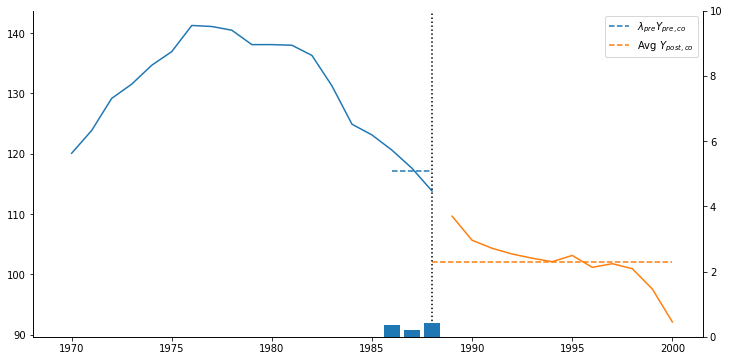

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# plot the mean of the control group before and after the treatment 
ax.plot(df.query("state!='California'").query("year<=1988").groupby('year').packspercapita.mean())
ax.plot(df.query("state!='California'").query("year>1988").groupby('year').packspercapita.mean())

# we did not include the intercept, so there is a little divergence
ax.hlines(df.query("state!='California'").query("year<=1988").groupby('year').packspercapita.mean()@res_lambda.x[1:], xmin=1986, xmax=1988, linestyle='--', label='$\lambda_{pre}Y_{pre, co}$')
ax.hlines(df.query("state!='California'").query("year>1988").groupby('year').packspercapita.mean().mean(), xmin=1988, xmax=2000, linestyle='--', color=colors[1], label='Avg $Y_{post, co}$')

ax.axvline(x=1988, color='black', linestyle=':')
ax.legend()

ax2 = ax.twinx()
ax2.bar(range(1970, 1989), res_lambda.x[1:], label="$\lambda$")
ax2.set_ylim(0,10)

sns.despine(top=True, right=False)

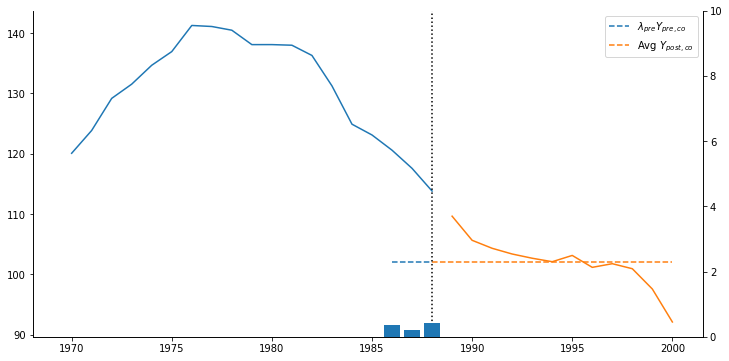

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# plot the mean of the control group before and after the treatment 
ax.plot(df.query("state!='California'").query("year<=1988").groupby('year').packspercapita.mean())
ax.plot(df.query("state!='California'").query("year>1988").groupby('year').packspercapita.mean())

# we include the intercept, so there is a little divergence
intercept = res_lambda.x[0]
ax.hlines(df.query("state!='California'").query("year<=1988").groupby('year').packspercapita.mean()@res_lambda.x[1:]+ intercept, xmin=1986, xmax=1988, linestyle='--', label='$\lambda_{pre}Y_{pre, co}$')
ax.hlines(df.query("state!='California'").query("year>1988").groupby('year').packspercapita.mean().mean(), xmin=1988, xmax=2000, linestyle='--', color=colors[1], label='Avg $Y_{post, co}$')

ax.axvline(x=1988, color='black', linestyle=':')
ax.legend()

ax2 = ax.twinx()
ax2.bar(range(1970, 1989), res_lambda.x[1:], label="$\lambda$")
ax2.set_ylim(0,10)

sns.despine(top=True, right=False)

#### 8.4 Compute the SDID estimator via the weighted DID regression

+ Now that we have both time $\lambda_t$ and unit $\omega_i $ weights, we can proceed to running the Diff-in-Diff part of the Synthetic DiD estimator.

\begin{equation}
\tag{1.1}
(\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}, \hat{\beta}) = \underset{\tau,\mu,\alpha,\beta}{\arg\min} \left\{ \sum_{i=1}^{N} \sum_{t=1}^{T} (Y_{it} - \mu - \alpha_{i} - \beta_{t} - W_{it}\tau)^2 \hat{\omega}_{i}^{sdid} \hat{\lambda}_{t}^{sdid} \right\}.
\end{equation}

+ The use of weights in the SDID estimator effectively makes the two-way fixed effect regression ``local``.

+ It emphasizes (puts more weight on) units that on average are similar in terms of their past to the target (treated) units.

+ It emphasizes periods that are on average similar to the target (treated) periods.

+ **Less intuitively**, the use of the weights can also improve the estimator’s precision by implicitly removing systematic (predictable) parts of the outcome.

+ ```Caveat:``` If there is little systematic heterogeneity in outcomes by either units or time periods, the unequal weighting of units and time periods may **worsen** the precision of the estimators relative to the DID estimator.

In [25]:
time_w = pd.DataFrame({'year': range(1970, 1989), 
                       'time_w': res_lambda.x[1:]})
unit_w = pd.DataFrame({'state': con.columns, 
                       'unit_w': res_omega.x[1:]})

# merge the weights to the original data
df = df.merge(time_w, on='year', how='left').merge(unit_w, on='state', how='left')
# For the time weights, we fill na with the average of the post-treatment dummy, which will be 1/N_{post-periods}
# For the unit weights, we fill na with the average of the treated dummy, which will be 1/N_{treated-units}

df.time_w.fillna(1/df.query("post_period==1").year.nunique(), inplace=True)
df.unit_w.fillna(1/df.query('tr_group==1').state.nunique(), inplace=True)

# compute the weights
df['weight'] = df.unit_w * df.time_w

+ Compute the SDiD as the weighted DiD

+ ```Flash back:```
The reason we can allow for this extra flexibility in the choice of weights (incldue the intercept) is that our use of fixed effects $\alpha_i$ will absorb any constant differences between different units.

+ That is what fixed effects actually do at the end of the day!

In [26]:
# TWFE DiD with weights
sdid_fit = sm.WLS.from_formula('packspercapita ~ 1 + treated + C(state) + C(year)', data=df, weights=df.weight+1e-10).fit()
ATT = sdid_fit.params['treated']
print("The SDiD estimated ATT is: ", ATT.round(3))

The SDiD estimated ATT is:  -15.642


+ This estimate is much smaller than the one we get with Diff-in-Diff, which might be biased.

+ The SDID estimate is smaller than the traditional SC estimate.

+ If we go back and look at the SC plot, we can see that cigarette sales in California started to fall below its synthetic control prior to Proposition 99.

+ This is probably due to the fact that traditional SCM has to match treated and control units in the entire pre-treatment period, causing it to miss one year or the other.

+ This is less of an issue in SDID, since the time weights allow us to focus just on the periods that are more similar to the post-intervention period.

In [27]:
# This is actually identical
sdid_fit = sm.WLS.from_formula('packspercapita ~ 1 + tr_group*post_period', data=df, weights=df.weight+1e-10).fit()
ATT = sdid_fit.params['tr_group:post_period']
print("The SDiD estimated ATT is: ", ATT.round(3))

The SDiD estimated ATT is:  -15.642


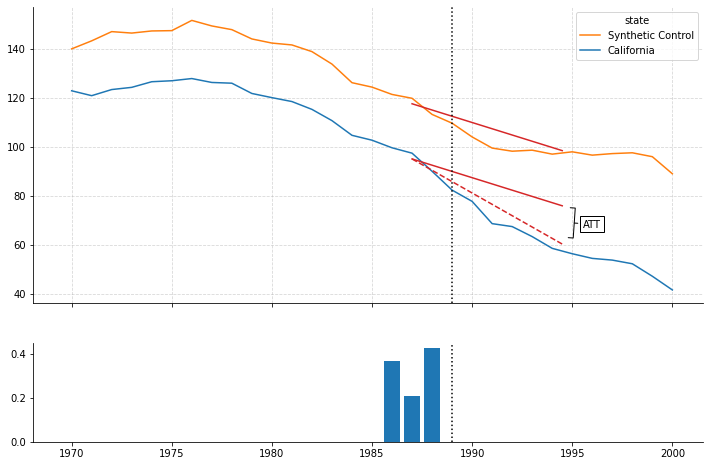

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

average_pre = int((time_w.year*time_w.time_w).sum())
average_post = 1989 + (2000-1989)/2

pre_sc = sdid_fit.params.Intercept
post_sc = pre_sc + sdid_fit.params.post_period

pre_tr = pre_sc + sdid_fit.params.tr_group
post_tr = pre_tr + sdid_fit.params['tr_group:post_period'] + sdid_fit.params.post_period
parallel = pre_tr + sdid_fit.params.post_period

sns.lineplot(df.query("tr_group==0").pivot(index='year', columns='state', values='packspercapita')@res_omega.x[1:], color=colors[1], label='Synthetic Control', ax=ax1)
sns.lineplot(df.query("tr_group==1").pivot(index='year', columns='state', values='packspercapita'), ax=ax1)


ax1.plot([average_pre, average_post], [pre_sc, post_sc], color=colors[3])
ax1.plot([average_pre, average_post], [pre_tr, parallel], color=colors[3])
ax1.plot([average_pre, average_post], [pre_tr, post_tr], color=colors[3], linestyle='--')

ax1.annotate('ATT', xy=(1995, 69), xytext=(1996, 66.4), 
             ha='center', va='bottom',
             bbox=dict(boxstyle='square', fc='white', color='k'),
             arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax1.axvline(x=1989, color='black', linestyle=':')
ax1.grid(alpha=0.5, linestyle='--')

ax2.bar(time_w.year, time_w.time_w)
ax2.axvline(x=1989, color='black', linestyle=':')
sns.despine()

### 9. The DIFP estimator
---

+ Suggested by Doudchenko and Imbens [2016] and Ferman and Pinto [2019].

+ The benefits of including unit fixed effects in the SC regression (1.3) can also be obtained by applying SCM after centering the data by subtracting, from each unit’s trajectory, its pre-treatment mean.

+ ```Keywords:``` centring by pre-treatment mean.

In [29]:
# pre-treatment mean
bystate_mean = df.query("year<=1988").groupby('state').packspercapita.mean().reset_index()

# merge
df = df.merge(bystate_mean, on='state', how='left')
# centring
df['packspercapita'] = df.packspercapita_x - df.packspercapita_y

In [30]:
# build the control and treated data before the treatment
control = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
treated = df.query("tr_group==1").query("post_period==0").pivot(index='year', columns='state', values='packspercapita').mean(axis=1)
X, y = check_X_y(control, treated)

# Initial guess for the weights
initial_w = (np.ones(X.shape[1])/X.shape[1])

# define the objective function
def objective_fun(w, X, y):
    return np.linalg.norm(y - X @ w)

# define the constraints, sum to 1
constraint = LinearConstraint(np.ones(X.shape[1]), lb= 1, ub= 1)
# define the bounds, all between 0 and 1
bounds = ((0, 1),) * X.shape[1]

# minimize the objective function
res_difp = minimize(objective_fun, x0=initial_w, args=(X, y), method='SLSQP', constraints=constraint, bounds=bounds)

In [31]:
# for the demeaned data for the following analysis
datt = pd.DataFrame(index=range(1970, 2001))
# the actual cigarette consumption in California
datt['packspercapita'] = df.query("state=='California'").packspercapita.values

# the synthetic cigarette consumption in California
datt['fitted'] = df.query("state!='California'").pivot(index='year', columns='state', values='packspercapita')@res_difp.x

# the residual
datt['residual'] = datt['packspercapita'] - datt['fitted']
print("The DIFP estimated ATT is: ", datt[datt.index>1988].residual.mean().round(3))

The DIFP estimated ATT is:  -11.108


Comparing between DiD, SCM, SDiD:
+ The estimated treatment effect can be expressed as the difference between adjusted outcome of treated and control units.

+ DiD uses constant weights $\hat{\omega}_i^{did}  = N_{co}^{-1}$.

\begin{equation}
\tag{2.4}
\hat{\tau} = \hat{\delta}_{tr} - \sum_{i=1}^{N_{co}} \hat{\omega}_{i} \hat{\delta}_{i} \quad \text{where} \quad \hat{\delta}_{tr} = \frac{1}{N_{tr}} \sum_{i=N_{co}+1}^{N} \hat{\delta}_{i}.
\end{equation}

+ $\delta_i$ is the outcome for unit $i$.

+ SC uses unweighted treatment period averages, 

+ DID uses unweighted differences between average treatment period and pre-treatment outcomes, 

+ SDID uses weighted differences of the same.

\begin{align*}
\hat{\delta}_{i}^{sc} &= \frac{1}{T_{\text{post}}} \sum_{t=T_{\text{pre}}+1}^{T} Y_{it}, \\

\hat{\delta}_{i}^{did} &= \frac{1}{T_{\text{post}}} \sum_{t=T_{\text{pre}}+1}^{T} Y_{it} - \frac{1}{T_{\text{pre}}} \sum_{t=1}^{T_{\text{pre}}} Y_{it}, \tag{2.5} \\

\hat{\delta}_{i}^{sdid} &= \frac{1}{T_{\text{post}}} \sum_{t=T_{\text{pre}}+1}^{T} Y_{it} - \sum_{t=1}^{T_{\text{pre}}} \hat{\lambda}_{t}^{sdid} Y_{it}.
\end{align*}

```Notice:``` for SCM, the $\hat{\delta_i} $ is the outcome for unit $i$, because the trajectory of pre-treatment synthetic control overlaps with treated ones. However, for DiD and SDiD, $\hat{\delta_i}$ is actually the difference in outcome before and after treatment!

### 10. SDiD for each period
---

In [32]:
df = pd.read_stata("data/prop99_example.dta")

In [33]:
def lambda_t(df, id, time, d, y):
    df['tr_group'] = df.groupby(id)[d].transform('max')
    df['post_period'] = df.groupby(time)[d].transform('max')

    pre = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
    post = df.query("tr_group==0").query("post_period==1").pivot(index='year', columns='state', values='packspercapita').mean(axis=0)

    X, y = check_X_y(pre.T, post)
    # add intercept
    X = sm.add_constant(X)

    # build abjective function
    def obj_fun_lambda(w, X, y):
        return np.linalg.norm(y - X @ w)

    # define the constraints, weights sum to 1, expcet intercept
    constraint_vec = np.ones(X.shape[1])
    constraint_vec[0] = 0
    constraint = LinearConstraint(constraint_vec, lb= 1, ub= 1)
    # define the bounds, all between 0 and 1, except intercept
    bounds = ((-np.inf, np.inf),) + ((0, 1),)*(X.shape[1]-1)

    # define the initial weights
    initial_w = (np.ones(X.shape[1])/X.shape[1])

    res_lambda = minimize(obj_fun_lambda, x0=initial_w, args=(X, y), method='SLSQP', constraints=constraint, bounds=bounds)

    return res_lambda

In [34]:
def omega_i(df, id, time, d, y):
    df['tr_group'] = df.groupby(id)[d].transform('max')
    df['post_period'] = df.groupby(time)[d].transform('max')

    # prepare control data and treated data
    tr = df.query("tr_group==1").query("post_period==0").pivot(index='year', columns='state', values='packspercapita').mean(axis=1)
    con = df.query("tr_group==0").query("post_period==0").pivot(index='year', columns='state', values='packspercapita')
    X, y =  check_X_y(con, tr)
    
    # remember to add intercept
    X = sm.add_constant(X)
    
    # compute the penalty
    n = df.query("tr_group==1").state.nunique()
    t = df.query('post_period==1').year.nunique()
    t_pre = df.query('post_period==0').year.nunique()
    
    sigma = df.query("tr_group==0").query("post_period==0").sort_values('year').groupby('state').packspercapita.diff().std()
    ksi = (n*t)**(1/4) * sigma
    
    # define the objective function, remember do not penliaty the intercept
    def obj_fun_omega(w, X, y, ksi):
        return np.sum((y - X @ w)**2) + ksi**2 * t_pre * np.linalg.norm(w[1:]**2)
    
    # constrain the sum of weights to 1, except fot the intercept
    constrain_vec = np.ones(X.shape[1])
    constrain_vec[0] = 0
    constraint = LinearConstraint(constrain_vec, lb= 1, ub= 1)
    # define the bounds, all between 0 and 1, except fot the intercept
    bounds = ((-np.inf, np.inf),) + ((0, 1),)* (X.shape[1]-1)
    
    # define the initial weights
    initial_w = (np.ones(X.shape[1])/X.shape[1])
    
    res_omega = minimize(obj_fun_omega, x0=initial_w, args=(X, y, ksi), method='SLSQP', constraints=constraint, bounds=bounds)

    return res_omega

In [35]:
def SDID(df, id, time, d, y):

    res_omega = omega_i(df, id=id, time=time, y=y, d=d)
    
    res_lambda = lambda_t(df, id=id, time=time, y=y, d=d)

    time_w = pd.DataFrame({time: df.query("post_period==0")[time].unique(), 
                           'time_w': res_lambda.x[1:]})
    unit_w = pd.DataFrame({id: df.query("tr_group==0")[id].unique(), 
                           'unit_w': res_omega.x[1:]})
    
    df = df.merge(time_w, on=time, how='left').merge(unit_w, on=id, how='left')
    df['time_w'].fillna(1/df.query("post_period==1")[time].nunique(), inplace=True)
    df['unit_w'].fillna(1/df.query("tr_group==0")[id].nunique(), inplace=True)
    
    df['weight'] = df.time_w * df.unit_w
    fit = sm.WLS.from_formula(f'{y} ~ 1 + tr_group*post_period', data=df, weights=df.weight+(1e-10)).fit()
    
    ATT = fit.params['tr_group:post_period']
    return ATT

In [36]:
effects = {}
for y in range(1989, 2001):
    data = df.query(f"(year<=1988) | (year=={y})").copy()
    ATT = SDID(data, id='state', time='year', d='treated', y='packspercapita')

    effects[y] = ATT

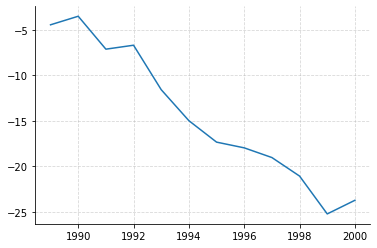

In [37]:
sns.lineplot(effects)
sns.despine()
plt.grid(alpha=0.5, linestyle='--')

### 11. Inforence via Placebo test
---

+ we use SDID to estimate the ATT of this placebo test and store its result.

+ We re-run this step multiple times, sampling a control unit each time

+ The variance of this array is the placebo variance of the SDID effect estimate, which we can use to construct a confidence interval.

$$
\hat{V}_{\tau}^{placebo} = B^{-1} \sum_{b=1}^{B} \left( \hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)} \right)^2
$$
$$
\tau \in \hat{\tau}^{sdid} \pm z_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$

In [38]:
# define a function to build a placebo dataset
def make_placebo(df):
    # randomly choose a state
    state = list(np.random.choice(df.state.unique(), 1))
    data = df.assign(**{'tr_group': np.where(df.state.isin(state), 1, 0),
                        'post_period': np.where(df.year>1988, 1, 0)})
    data = data.assign(**{'treated': lambda x: x.tr_group*x.post_period})

    return data

In [39]:
from joblib import Parallel, delayed
from functools import partial

# define a function to compute the standard error of placebo ATT
def estimate_se(df, id, time, d, y, n_jobs, n_bootstrap):
    sdid = partial(SDID, id=id, time=time, d=d, y=y)
    att = Parallel(n_jobs=n_jobs)(delayed(sdid)(make_placebo(df)) for _ in range(n_bootstrap))
    return np.std(att)

In [40]:
effects = {}
for y in range(1989, 2001):
    data = df.query(f"(year<=1988) | (year=={y})").copy()
    ATT = SDID(data, id='state', time='year', d='treated', y='packspercapita')
    se = estimate_se(data, id='state', time='year', d='treated', y='packspercapita', n_jobs=4, n_bootstrap=100)

    effects[y] = ATT, se

In [41]:
# convert the dictionary to dataframe
df_effects = pd.DataFrame.from_dict(effects).T

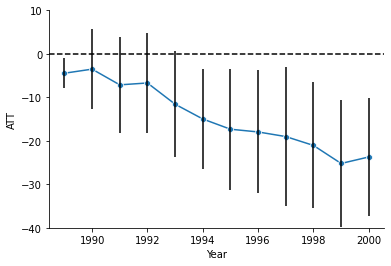

In [42]:
sns.lineplot(x=df_effects.index, y=df_effects[0], marker='o')
plt.errorbar(x=df_effects.index, y=df_effects[0], yerr=df_effects[1], fmt='none', color='black')
plt.ylim(-40, 10)
plt.ylabel('ATT')
plt.xlabel('Year')
plt.axhline(y=0, color='black', linestyle='--')
sns.despine()

### 12. Time effect heterogeneity and staggered adoption
---

In [43]:
df = pd.read_stata("data/prop99_example.dta")
df['tr_group'] = df.groupby('state').treated.transform('max')
df['post_period'] = df.groupby('year').treated.transform('max')

In [44]:
# simulate 3 states with similar treatment starts at 1993, effect is -3% afterward
np.random.seed(1)

states = list(np.random.choice(df.state.unique(), 3, replace=False))
sim_state = df.query("state in @states").assign(**{'tr_group': 1,
                                                   'state': lambda d: 'new_' + d.state.astype(str),
                                                   'post_period': lambda d: (d.year>=1993).astype(int)})

sim_state = sim_state.assign(**{'treated': lambda d: d.tr_group * d.post_period,
                                'packspercapita': lambda d: d.packspercapita*(1 - 0.03*(d.year-1992)*d.treated)+ np.random.normal(0, 1, size=d.shape[0])*d.treated})
# append data
df_new = pd.concat([df, sim_state]).sort_values(['state', 'year'])

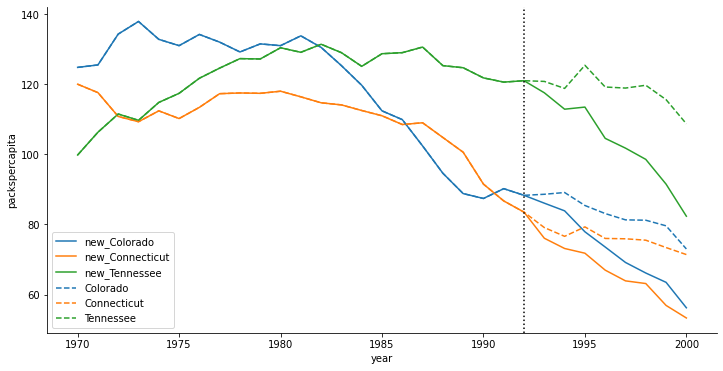

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
sim_state_name = list(filter(lambda c: str(c).startswith('new'), df_new.state.unique()))
sns.lineplot(df_new.query("state in @sim_state_name"), x='year', y='packspercapita', hue='state', ax=ax1)

ori_state_name = [name.replace('new_', '') for name in sim_state_name]
sns.lineplot(df_new.query("state in @ori_state_name"), x='year', y='packspercapita', hue='state', linestyle='--', ax=ax1)

ax1.axvline(x=1992, color='black', linestyle=':')
ax1.legend()
sns.despine()

In [46]:
assignment_blocks = df_new.query("treated==1").groupby('state').year.min().reset_index().groupby('year').state.apply(list).to_dict()
assignment_blocks

{1989: ['California'],
 1993: ['new_Colorado', 'new_Connecticut', 'new_Tennessee']}

In [47]:
# compute the treatment effect in 1989, we need to remove the new states
data = df_new.query(f"~state.isin({sim_state_name})").copy()
att_1989 = SDID(data, id='state', time='year', d='treated', y='packspercapita')
print("The ATT in 1989 is: ", att_1989.round(3))

The ATT in 1989 is:  -15.642


In [48]:
# compute the treatment effect in 1989, we need to remove California
data = df_new.query("state!='California'").copy()
# remember to change variable post_period
data['post_period'] = data.groupby('year').treated.transform('max')

att_1993 = SDID(data, id='state', time='year', d='treated', y='packspercapita')
print("The ATT in 1993 is: ", att_1993.round(3))

The ATT in 1993 is:  -13.067


the weight for the first ATT is 12/36, which is the number of observations in the first block divided by the total number of observations treated. For the second Att, 24/36, which combines to the result below.

In [49]:
# compute weights for each block of assignment, it is the number of observations in each block
weights = {year: sum((df_new["year"] >= year) & (df_new["state"].isin(states)))
           for year, states in assignment_blocks.items()}

staggered_effects = {1989: att_1989,
                      1993: att_1993}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])
print("The weights:", weights)
print("The weighted ATT is: ", att.round(3))

The weights: {1989: 12, 1993: 24}
The weighted ATT is:  -13.925


### 13. Appendix
---

### 1. Formal results
---
#### 1.1 The settings

The data generating process follows a latent factor model, also referred to as an “interactive fixed-effects model”, Xu (2017)

\begin{equation}
\tag{3.1}
Y_{it} = \gamma_i\upsilon_t^T + \tau W_{it} + \epsilon_{it}
\end{equation}

where $\gamma_i$ is a vector of latent unit factors of dimension R, and $\nu_t$ is a vector of latent time factors
of dimension R.

In matrix form it can be written as:
\begin{equation}
\tag{3.2}
\mathbb{Y} = \mathbb{L} + \tau \mathbb{W} + \mathbb{E} \quad where \quad \mathbb{L}=\mathbb{\Gamma}\mathbb{\Upsilon}^T
\end{equation}

Where $\mathbb{L}$ is the systematic component. 

+ The conditional expectation of the error matrix $\mathbb{E}$ given the assignment matrix $\mathbb{W}$ and the systematic component $\mathbb{L}$ is zero.

+ That is, the treatment assignment cannot depend on $\mathbb{E}$.

+ However, the treatment assignment may in general depend on the systematic component $\mathbb{L}$.

+ That is we do not take $\mathbb{W}$ to be randomized.



We write the identical version of equation (3.1)
\begin{equation}
\tag{4.1}
\mathbb{Y} = \mathbb{L} + \mathbb{W} \circ \mathbb{\tau} + \mathbb{E} \quad where \quad \mathbb{W} \circ \mathbb{\tau} = W_{it} \tau_{it}
\end{equation}

Where $L=\Gamma \Upsilon$ is a systematic component, $\Gamma = UD^{1/2}$ and $\Upsilon^T=D^{1/2}V^T$ in terms of sigular value decomposition $L=UDV^T$. Our estimand is the average treatment effect for treated under block assignment:

\begin{equation}
\tag{4.2}
\tau = \frac{1}{N_{tr}T_{post}} \sum_{i=N_{co}+1}^N \sum_{t=T_{pre}+1}^T \tau_{it}
\end{equation}

$E_i$ are homoskadastistic across units but not across time. That is, $Var[E_i]=\Sigma \in R^{T\times T}$, for all units $i=1, \cdots, n$. We partition $\Sigma$ as:
$$
\Sigma = \left( \begin{array}{cc}
\Sigma_{pre,pre} & \Sigma_{pre,post} \\
\Sigma_{post,pre} & \Sigma_{post,post}
\end{array} \right)
$$

```Goal:``` under this setting we focus on how SDiD can recover $\tau$.

1. Under this assignment, we do not need to estimate the complicated systematic component $L$, unit weight $\hat{\omega}$ balance out $\Gamma$ and time weight $\hat{\lambda}$ balance out $\Upsilon$. Here, it also shows a type of double robustness property.

2. The use of two-way fixed effects and intercept makes the SDID estimator invariant to additive shocks to any row or column. That is if $L_{it} \leftarrow L_{it} + \alpha_i + \beta+t $, the SDiD estimator is still unbaised.



#### 1.2 Weighted double differencing estimators

For any $\omega \ni \Omega$ and $\lambda \in \Lambda$ we can define a double diffferencing estimator:

\begin{equation}
\tag{4.3}
\hat{\tau}(\omega, \lambda) = \omega_{tr}^T Y_{tr,post} \lambda_{post} - \omega_{co}^T Y_{co,post} \lambda_{post} - \omega_{tr}^T Y_{tr,pre} \lambda_{pre} + \omega_{co}^T Y_{co,pre} \lambda_{pre}.
\end{equation}

Decompose the error of any weighted double-differencing estimator as the sum of a bias and a noise component:

\begin{equation}
\tag{4.4}
\begin{split}

\hat{\tau}(\omega, \lambda) - \tau &= \underbrace{\omega_{tr}^T L_{tr,post} \lambda_{post} - \omega_{co}^T L_{co,post} \lambda_{post} - \omega_{tr}^T L_{tr,pre} \lambda_{pre} + \omega_{co}^T L_{co,pre} \lambda_{pre}}_{\text{bias} \: B(\omega,\lambda)} \\

&+ \underbrace{\omega_{tr}^T E_{tr,post} \lambda_{post} - \omega_{tr}^T E_{tr,co} \lambda_{co} - \omega_{tr}^T E_{tr,pre} \lambda_{pre} + \omega_{co}^T E_{co,pre} \lambda_{pre}}_{\text{noise} \: \epsilon(\omega,\lambda)}.

\end{split}
\end{equation}




### 1.3 Oracle and adaptive ssynthetic control weights 

We construct alternative deterministic "oracle" weights: 

\begin{equation}
\tag{4.5}
(\tilde{\omega}_0, \tilde{\omega}) = \underset{\omega_0 \in \mathbb{R},\omega \in \Omega}{\arg \min} \mathbb{E} [\ell_{unit}(\omega_0, \omega)],
\quad
(\tilde{\lambda}_0, \tilde{\lambda}) = \arg \min_{\lambda_0 \in \mathbb{R},\lambda \in \Lambda} \mathbb{E} [\ell_{time}(\lambda_0, \lambda)].
\end{equation}

The optimation problem is slightly different from before:

\begin{equation}
\tag{4.6}
(\tilde{\omega}_0, \tilde{\omega}) = \underset{\omega_0 \in \mathbb{R},\omega \in \Omega}{\arg \min} \left\| \omega_0 + \omega_{co}^T L_{co,pre} - \omega_{tr}^T L_{tr,pre} \right\|_2^2 + \left( tr(\Sigma_{pre,pre}) \right) + \xi^2 T_p \left\| \omega \right\|_2^2,
\end{equation}

\begin{equation}
\tag{4.7}
\begin{split}
(\tilde{\lambda}_0, \tilde{\lambda}) &= \underset{\lambda_0 \in \mathbb{R},\lambda \in \Lambda}{\arg \min} \left\| \lambda_0 + L_{co,pre}\lambda_{pre} - L_{co,post}\lambda_{post} \right\|_2^2 + \left\| \tilde{\Sigma} \right\|_2^2, \\

& where \quad \tilde{\Sigma} = \left( \begin{array}{cc}
\Sigma_{pre,pre} & -\Sigma_{pre,post} \\
-\Sigma_{post,pre} & \Sigma_{post,post}
\end{array} \right).
\end{split}
\end{equation}

The error of the SDiD estimator can now be decomposed as follows:
\begin{equation}
\tag{4.8}
\hat{\tau}^{sdid} - \tau = \underbrace{\varepsilon(\tilde{\omega}, \tilde{\lambda})}_{\text{oracle noise}} + \underbrace{B(\tilde{\omega}, \tilde{\lambda})}_{\text{oracle confounding bias}} + \underbrace{\hat{\tau}(\hat{\omega}, \hat{\lambda}) - \tilde{t}(\tilde{\omega}, \tilde{\lambda})}_{\text{deviation from oracle}}.
\end{equation}

```3 observations:```

1. The oracle noise term tends to be small when the weights are not too concentrated.

2. The oracle confounding bias will be small either when the pre-exposure oracle row regression fits well and generalizes to the exposed rows, or when the unexposed oracle column regression fits well and generalizes to the exposed columns.

3. Core theoretical claim, formalized in our asymptotic analysis, is that the SDID
estimator will be close to the oracle when the oracle unit and time weights look promising on
their respective training sets.

Finally, we comment briefly on the behavior of the oracle time weights $\tilde{\lambda}$ in the presence of autocorrelation over time. When $\Sigma$ is not diagonal, the effective regularization term in (4.7) does not shrink $\tilde{\lambda}_{pre}$ towards zero, but rather toward an autoregression vector:

\begin{equation}
\tag{4.9}
\psi = \underset{v \in \mathbb{R}^{T_{\text{pre}}}}{\arg \min} \left\| \tilde{\Sigma} \left( \begin{array}{c}
v \\
\lambda_{\text{post}}
\end{array} \right) \right\| = \Sigma_{\text{pre,pre}}^{-1} \Sigma_{\text{pre,post}} \lambda_{\text{post}}.
\end{equation}

Here $\lambda_{post}$ is the $T_{post}$-component column vector with all elements equal to $1/T_{post}$ and $\psi$ is the population regression coefficient in a regression of the average of the post-treatment errors on the pre-treatment errors. In the absence of autocorrelation, $\psi$ is zero, but when autocorrelation is present, shinkage toward $\psi$ reduces the variance of the SDID estimator—and enables us to gain precision over the basic DID estimator (1.2) even when the two-way fixed effects model is correctly specified. This explains some of the behavior noted in the simulations.

#### 1.4 Asymptotic properties

```Assumption 1: ``` 
(Property of errors)


The rows $E_i$ of the noise matrix are i.i.d Gaussian vectors and the eigenvalues of its covariance matrix $\Sigma$ are bounded and bounded away from zero.

```Assumption 2: ``` 
(Sample size)


1. The product $N_{tr}T_{post}$ goes to infinity, and both $N_{co}$ and $T_{pre}$ go to infinity,
2. The ratio $T_{pre}/N_{co}$ is bounded and bounded away from zero,
3. $N_{co}/(N_{tr}T_{post} max(N_{tr}, T_{post}) log^2(N_{co})) \rightarrow \inf$.

```Assumption 3:```
(Property of $L$)

Letting $\sigma_1(\Gamma), \sigma_2(\Gamma), . . .$ denote the singular values of the matrix $\Gamma$ in decreasing order and R the largest integer less than $\sqrt{min(T_{tre}, N_{co})}$,
\begin{equation}
\tag{4.10}
\sigma_R(L_{co,pre})/R = o \left( \min \left\{ N_{tr}^{-1/2} \log^{-1/2}(N_{co}), T_{post}^{-1/2} \log^{-1/2}(T_{pre}) \right\} \right).
\end{equation}

```Assumption 4:```
(Properties of weights and $L$)

The oracle unit weights $\tilde{\omega}$ satisfy:

\begin{equation}
\tag{4.11}
\begin{split}
& \left\| \tilde{\omega}_{co} \right\|_2 = o\left(\left(N_{tr} T_{post} \log(N_{co})\right)^{-1/2}\right) \text{ and } \\

& \left\| \tilde{\omega}_0 + \tilde{\omega}_{co}^T L_{co,pre} - \tilde{\omega}_{tr}^T L_{tr,pre} \right\|_2 = o\left(N_{co}^{1/4} \left(N_{tr} T_{post} \max(N_{co}, T_{post})\right)^{-1/4} \log^{-1/2}(N_{co})\right),
\end{split}
\end{equation}

The oracle time weights $\tilde{\lambda}$ satisfy:

\begin{equation}
\tag{4.12}
\begin{split}
& \left\| \tilde{\lambda}_{\text{pre}} - \psi \right\|_2 = o\left(\left(N_{tr} T_{post} \right) \log(N_{co})^{-1/2}\right) \text{ and } \\

& \left\| \tilde{\lambda}_0 + L_{co,pre} \tilde{\lambda}_{\text{pre}} - L_{co,post} \tilde{\lambda}_{\text{post}} \right\|_2 = o\left(N_{co}^{1/4} \left(N_{tr} T_{post} \right)^{-1/8}\right),
\end{split}
\end{equation}

And the oracle weights jointly satisfy:

\begin{equation}
\tag{4.13}
\tilde{\omega}_{tr}^T L_{tr,post} \tilde{\lambda}_{\text{post}} - \tilde{\omega}_{co}^T L_{co,post} \tilde{\lambda}_{\text{post}} - \tilde{\omega}_{tr}^T L_{tr,pre} \tilde{\lambda}_{\text{pre}} + \tilde{\omega}_{co}^T L_{co,pre} \tilde{\lambda}_{\text{pre}} = o\left( \left( N_{tr} T_{post} \right)^{-1/2} \right).
\end{equation}

```Theorem 1```

Under the model (4.1) with $L$ and $W$ taken as fixed, suppose that we run the SDID estimator (1.1) with regularization parameter $\zeta$ satisfying $(N_{tr}T_{post})^{1/2} log(N_{co}) = o(\zeta ^2)$. Suppose moreover that Assumptions 1-4 hold. Then,

\begin{equation}
\tag{4.14}
\hat{t}^{\text{sdid}} - \tau = \frac{1}{N_{tr}} \sum_{i=N_{co}+1}^{N} \left( \frac{1}{T_{\text{post}}} \sum_{t=T_{\text{pre}}+1}^{T} \epsilon_{it} - E_{i,\text{pre}}\psi \right) + o_{p} \left( \left(N_{tr} T_{\text{post}}\right)^{-1/2} \right),
\end{equation}

And consequently

\begin{equation}
\tag{4.15}
\left( \hat{t}^{\text{sdid}} - \tau \right) / V_{\tau}^{1/2} \Rightarrow \mathcal{N}(0, 1), \text{ where } V_{\tau} = \frac{1}{N_{tr}} \text{Var} \left[ \frac{1}{T_{\text{post}}} \sum_{t=T_{\text{pre}}+1}^{T} \epsilon_{it} - E_{i,\text{pre}}\psi \right].
\end{equation}


### 2. Large sample inference
---

The asymptotic result from the previous section can be used to motivate practical methods for large-sample inference using SDID. If these assumptions hold and we have a consistent estimator for its asymptotic variance $V_{\tau}$, we can use conventional confidence intervals:

\begin{equation}
\tag{5.1}
\tau \in \hat{t}^{\text{sdid}} \pm z_{\alpha/2} \sqrt{\hat{V}_{\tau}}
\end{equation}

We can use Boostrap or Jackknife variance estimation to construct confidence interval.

```Bootstrap variance estimation```

_Computationally expensive_
$$ 
\hat{V}_{\tau}^b = \frac{1}{B} \sum_{b=1}^{B} \left( \hat{\tau}^{(b)} - \frac{1}{B} \sum_{b=1}^{B} \hat{\tau}^{(b)} \right)^2
$$

```Theorem 2```
Suppose that the elements of $L$ are bounded. Then, under the conditions of ```Theorem 1```, the jackknife variance estimator yields conservative confidence intervals, i.e., for any $0 < \alpha < 1$,

\begin{equation}
\tag{5.2}
\liminf \mathbb{P} \left[ \tau \in \hat{\tau}^{\text{sdid}} \pm z_{\alpha/2} \sqrt{\hat{V}_{\tau}^{\text{jack}}} \right] \geq 1 - \alpha.
\end{equation}

Moreover, if the treatment effects $\tau_{it} = \tau$ are constant and
\begin{equation}
\tag{5.3}
T_{\text{post}} N_{tr}^{-1} \left\| \hat{\lambda}_0 + L_{tr,pre} \hat{\lambda}_{\text{pre}} - L_{tr,post} \hat{\lambda}_{\text{post}} \right\|_2^2 \overset{p}{\to} 0,
\end{equation}

Under theorem 2 we can use Jackknife estimate for inference.

```Jackknife variance estimation```

_Weights are fixed each time_

$$
\hat{V}_{\tau}^{\text{jack}} = (N - 1)N^{-1} \sum_{i=1}^{N} (\hat{\tau}^{(-i)} - \hat{\tau})^2
$$

```Placebo variance estimation```

_Based on the assumption of homoskedasticity across units_

$$
\hat{V}_{\tau}^{\text{placebo}} = \frac{1}{B} \sum_{b=1}^{B} \left( \hat{\tau}^{(b)} - \frac{1}{B} \sum_{b=1}^{B} \hat{\tau}^{(b)} \right)^2
$$

Placebo test is sampling control $N_{tr}$ out of the $N_{co}$, however Bootstrap is sampling units $i$ out of $1, ..., N$.
